In [1]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df_daily = pd.read_csv('data/daily.csv', parse_dates=['date'])
df_daily.describe()

,date,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_origValue,WTEQ_value,site_no,CFS
count,12584,12344.000000,12343.000000,12584.000000,12584.000000,12584.000000,12584.0,12584.000000
mean,2007-03-24 12:00:00,33.649141,33.656769,9.789860,9.666910,9.685386,6043500.0,820.263907
min,1990-01-01 00:00:00,-37.300000,-37.300000,0.000000,-4.700000,0.000000,6043500.0,153.000000
25%,1998-08-12 18:00:00,23.400000,23.400000,0.600000,0.100000,0.000000,6043500.0,313.000000
50%,2007-03-24 12:00:00,33.400000,33.400000,8.300000,7.800000,7.800000,6043500.0,416.000000
75%,2015-11-03 06:00:00,44.800000,44.800000,17.400000,16.600000,16.600000,6043500.0,748.000000
max,2024-06-14 00:00:00,67.300000,67.300000,26.200000,40.800000,40.800000,6043500.0,8400.000000
std,NaN,14.645176,14.649297,8.855776,9.542158,9.536314,0.0,985.361326


In [3]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12584 entries, 0 to 12583
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            12584 non-null  datetime64[ns]
 1   TAVG_flag       12344 non-null  object        
 2   TAVG_origFlag   12344 non-null  object        
 3   TAVG_origValue  12344 non-null  float64       
 4   TAVG_value      12343 non-null  float64       
 5   WTEQ_average    12584 non-null  float64       
 6   WTEQ_flag       12584 non-null  object        
 7   WTEQ_origFlag   12584 non-null  object        
 8   WTEQ_origValue  12584 non-null  float64       
 9   WTEQ_value      12584 non-null  float64       
 10  agency_cd       12584 non-null  object        
 11  site_no         12584 non-null  int64         
 12  CFS             12584 non-null  int64         
 13  status          12584 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(6)


In [4]:
df_daily = df_daily.loc[df_daily["date"] < pd.to_datetime('2024-06-15')]
df_daily.tail()

,date,TAVG_flag,TAVG_origFlag,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_flag,WTEQ_origFlag,WTEQ_origValue,WTEQ_value,agency_cd,site_no,CFS,status
12579,2024-06-10,V,V,43.7,43.7,12.3,V,V,9.8,9.8,USGS,6043500,5360,P
12580,2024-06-11,V,V,47.3,47.3,11.9,V,V,8.3,8.3,USGS,6043500,4540,P
12581,2024-06-12,V,V,48.4,48.4,11.3,V,V,7.0,7.0,USGS,6043500,4140,P
12582,2024-06-13,V,V,49.3,49.3,10.7,V,V,5.6,5.6,USGS,6043500,3680,P
12583,2024-06-14,V,V,52.0,52.0,10.1,V,V,4.0,4.0,USGS,6043500,3390,P


In [5]:
col_names = {'date': 'ds', 'CFS': 'y'}
df = df_daily[['date', 'TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue', 'CFS']].copy()
df = df.rename(columns=col_names)
df.ffill(inplace=True)
df['y'] = np.log(df['y']) # NOTE! we are fitting the logged CFS value to normalize it.
lags = [1, 2, 3]  # Example: Create 1-day, 2-day, and 3-day lags
for lag in lags:
    df[f'TAVG_lag_{lag}'] = df['TAVG_origValue'].shift(lag)
df.dropna(inplace=True)

cutoff = pd.to_datetime("2024-01-01")
train = df.loc[df["ds"] < cutoff]
test = df.loc[df["ds"] >= cutoff]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12581 entries, 3 to 12583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              12581 non-null  datetime64[ns]
 1   TAVG_origValue  12581 non-null  float64       
 2   WTEQ_average    12581 non-null  float64       
 3   WTEQ_origValue  12581 non-null  float64       
 4   y               12581 non-null  float64       
 5   TAVG_lag_1      12581 non-null  float64       
 6   TAVG_lag_2      12581 non-null  float64       
 7   TAVG_lag_3      12581 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 884.6 KB


# Fit initial model on only y (no covariates)

In [6]:
m = Prophet(seasonality_mode="multiplicative", 
            growth='flat')
m.fit(train)

17:39:03 - cmdstanpy - INFO - Chain [1] start processing
17:39:03 - cmdstanpy - INFO - Chain [1] done processing


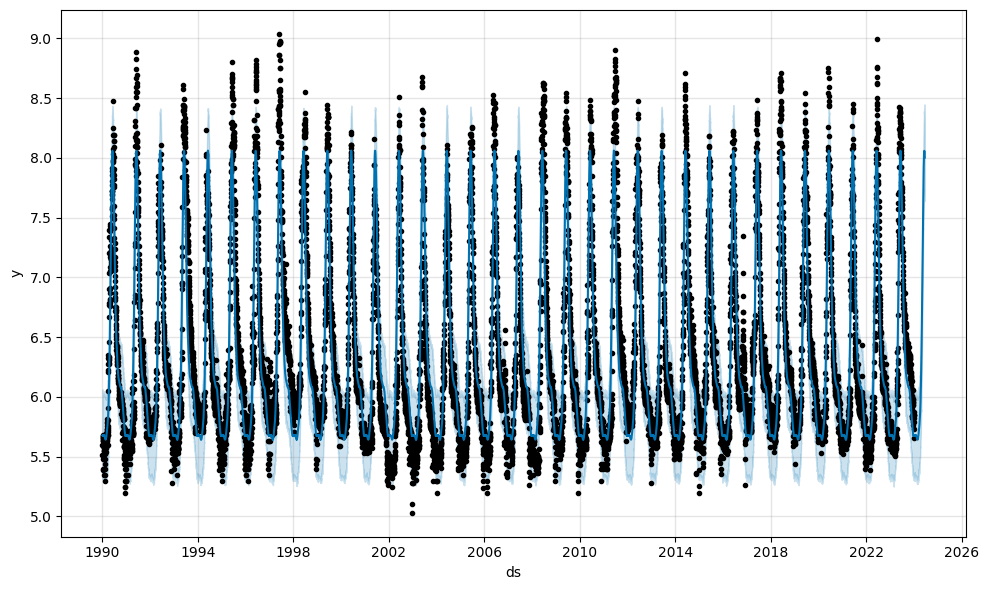

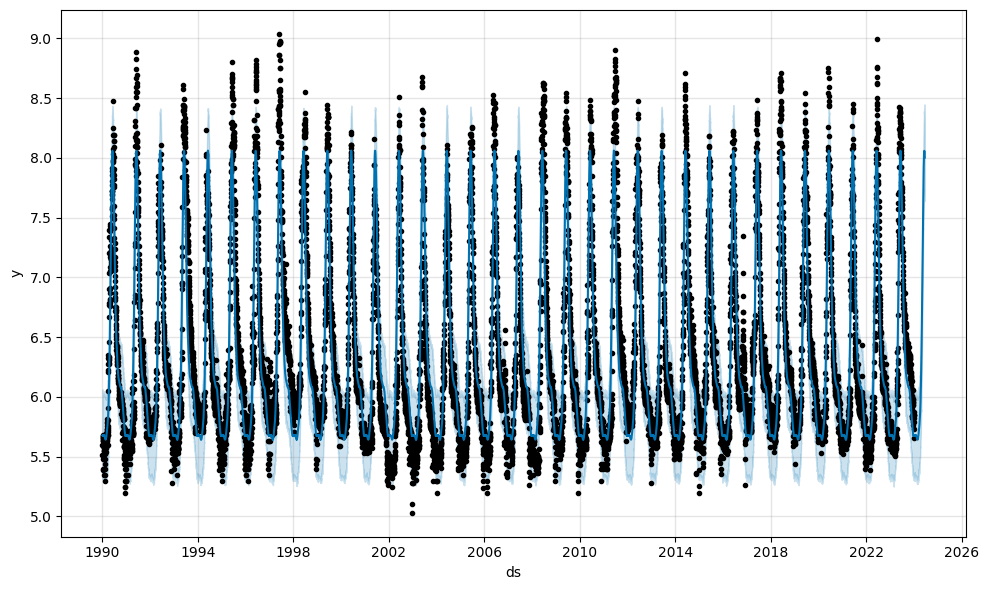

In [7]:
periods_forward = len(test) - 1
future = m.make_future_dataframe(periods=periods_forward)
forecast = m.predict(future)
m.plot(forecast)

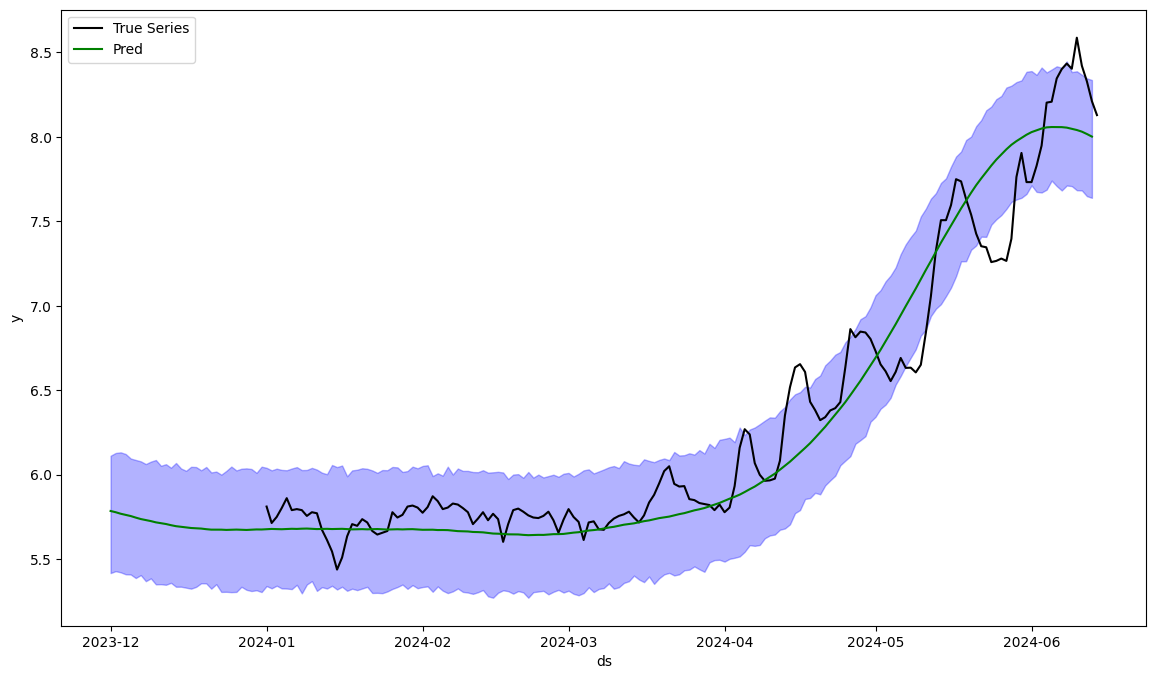

In [8]:
tail = len(test) + 30
plt.figure(figsize=(14, 8))

sns.lineplot(x='ds', y='y', data=test, label='True Series', color='black')

sns.lineplot(x='ds', y='yhat', data=forecast.tail(tail), label='Pred', color='green')
plt.fill_between(forecast['ds'].tail(tail), forecast['yhat_lower'].tail(tail), forecast['yhat_upper'].tail(tail), color='blue', alpha=0.3)

# sns.lineplot(x='time', y='pred2', data=forecast, label='Prediction 2', color='red')
# plt.fill_between(df['time'], df['ci_lower2'], df['ci_upper2'], color='red', alpha=0.3)
plt.show()

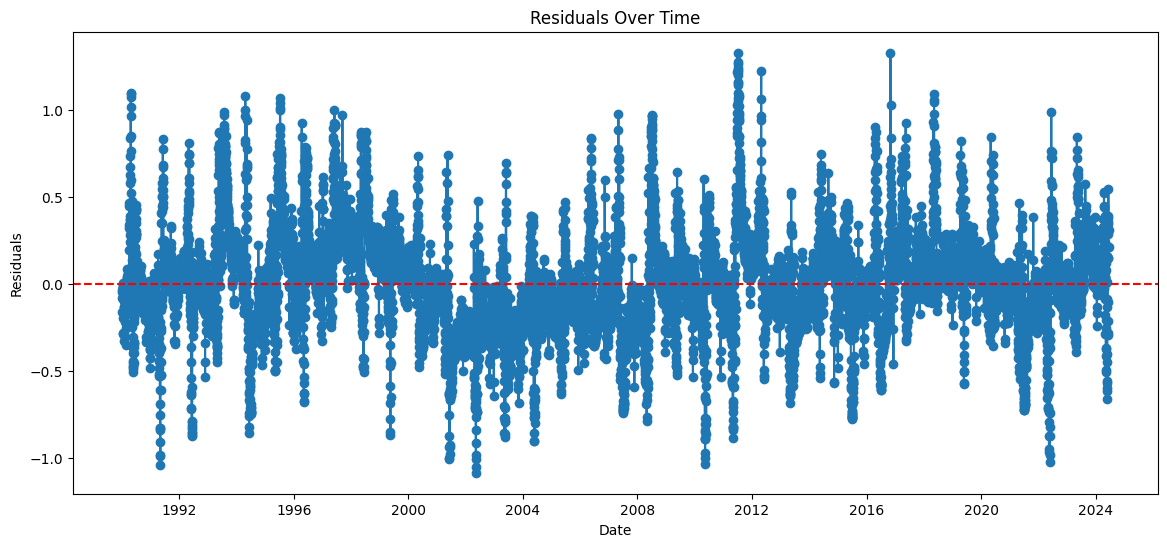

In [9]:
df_merged = df.set_index('ds').join(forecast.set_index('ds'))

# Calculate residuals
df_merged['residuals'] = df_merged['y'] - df_merged['yhat']
plt.figure(figsize=(14, 6))
plt.plot(df_merged.index, df_merged['residuals'], marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

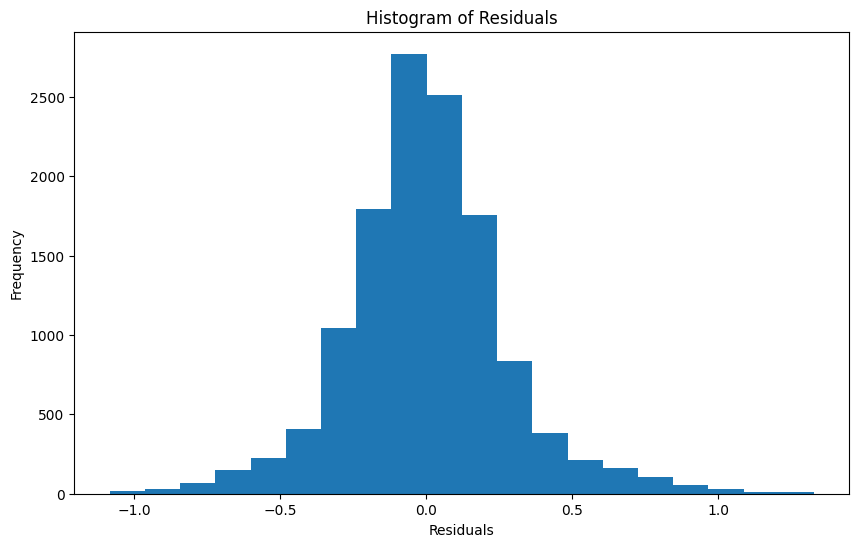

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df_merged['residuals'], bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

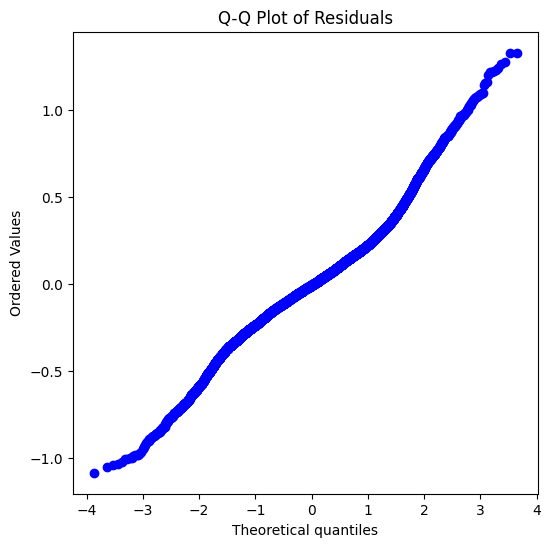

In [11]:
plt.figure(figsize=(6, 6))
stats.probplot(df_merged['residuals'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Now with covariates

In [12]:
mc = Prophet(seasonality_mode="multiplicative", 
            growth='flat')
mc.add_regressor('TAVG_origValue', mode='multiplicative')
mc.add_regressor('TAVG_lag_1', mode='multiplicative')
mc.add_regressor('TAVG_lag_2', mode='multiplicative')
mc.add_regressor('TAVG_lag_3', mode='multiplicative')
mc.add_regressor('WTEQ_average', mode='multiplicative')
mc.add_regressor('WTEQ_origValue', mode='multiplicative')
mc.fit(train)

17:39:05 - cmdstanpy - INFO - Chain [1] start processing
17:39:05 - cmdstanpy - INFO - Chain [1] done processing


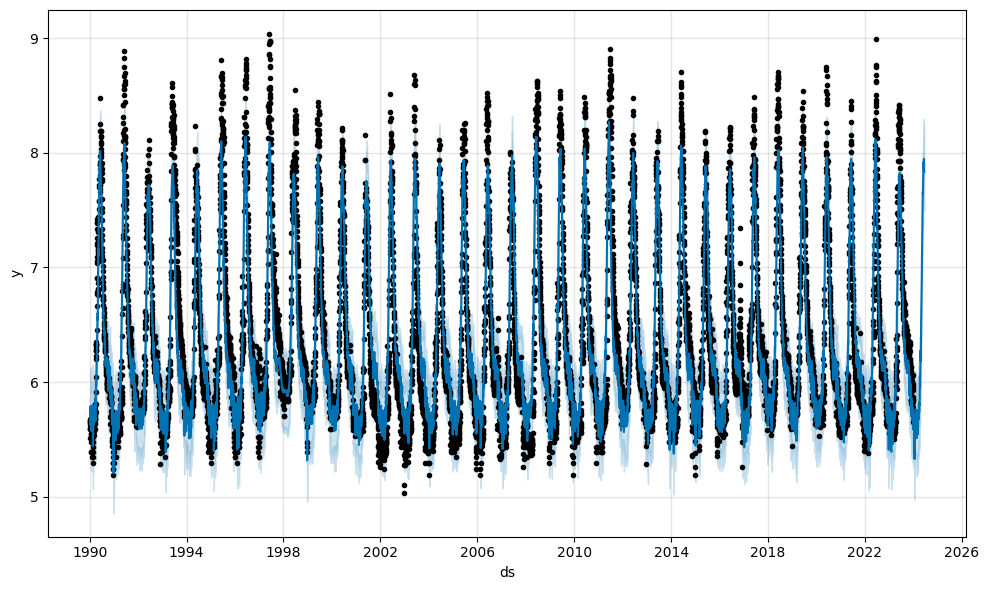

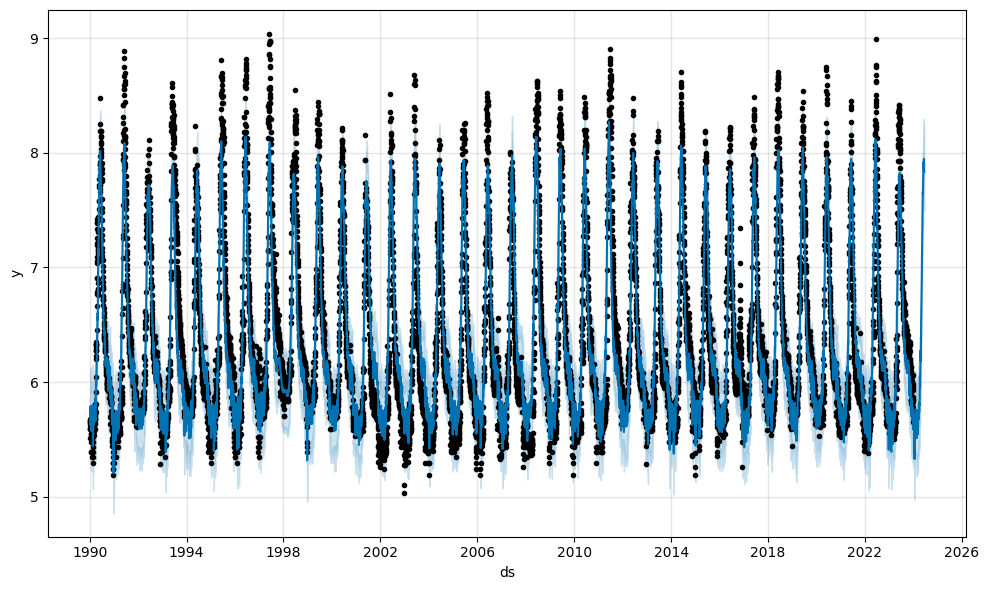

In [13]:
future_c = mc.make_future_dataframe(periods=periods_forward)
future_c['TAVG_origValue'] = df['TAVG_origValue']
future_c['TAVG_lag_1'] = df['TAVG_lag_1']
future_c['TAVG_lag_2'] = df['TAVG_lag_2']
future_c['TAVG_lag_3'] = df['TAVG_lag_3']
future_c['WTEQ_average'] = df['WTEQ_average']
future_c['WTEQ_origValue'] = df['WTEQ_origValue']
future_c.dropna(inplace=True)
forecast_c = mc.predict(future_c)
mc.plot(forecast_c)

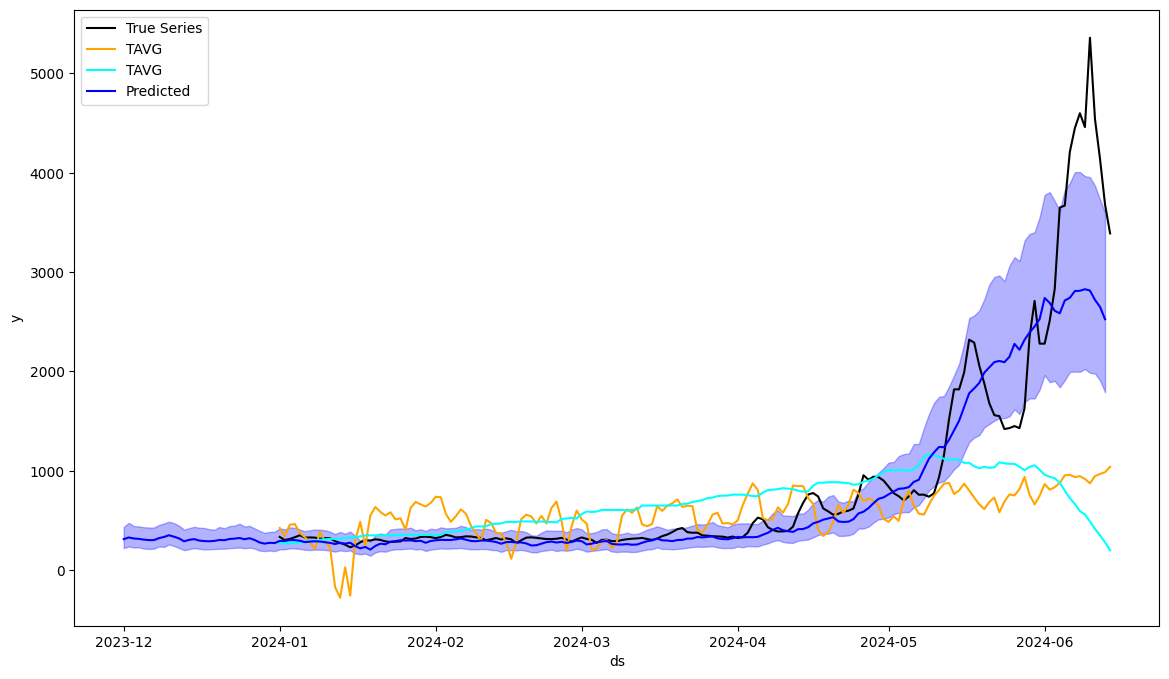

In [14]:
tail = len(test) + 30
plt.figure(figsize=(14, 8))
test_untransformed = test.copy()
test_untransformed['y'] = test['y'].apply(np.exp)
test_untransformed['TAVG_scaled_up'] = test['TAVG_origValue'].apply(lambda x: x*20)
test_untransformed['WTEQ_origValue'] = test['WTEQ_origValue'].apply(lambda x: x*50)

forecast_untransformed = forecast_c.copy()
forecast_untransformed['yhat'] = forecast_c['yhat'].apply(np.exp)
forecast_untransformed['yhat_lower'] = forecast_c['yhat_lower'].apply(np.exp)
forecast_untransformed['yhat_upper'] = forecast_c['yhat_upper'].apply(np.exp)
sns.lineplot(x='ds', y='y', data=test_untransformed, label='True Series', color='black')
sns.lineplot(x='ds', y='TAVG_scaled_up', data=test_untransformed, label='TAVG', color='orange')
sns.lineplot(x='ds', y='WTEQ_origValue', data=test_untransformed, label='TAVG', color='aqua')

sns.lineplot(x='ds', y='yhat', 
             data=forecast_untransformed.tail(tail), 
             label='Predicted',
             color='blue')
plt.fill_between(forecast_untransformed['ds'].tail(tail),
                 forecast_untransformed['yhat_lower'].tail(tail),
                 forecast_untransformed['yhat_upper'].tail(tail),
                 color='blue', alpha=0.3)

# sns.lineplot(x='time', y='pred2', data=forecast, label='Prediction 2', color='red')
# plt.fill_between(df['time'], df['ci_lower2'], df['ci_upper2'], color='red', alpha=0.3)
plt.show()

# Compare metrics between the two models

In [15]:
df_cv = cross_validation(m, initial='1825 days', period='180 days', horizon = '365 days', parallel="processes")
dfc_cv = cross_validation(mc, initial='1825 days', period='180 days', horizon = '365 days', parallel="processes")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:39:08 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
17:39:08 - cmdstanpy - INFO - Chain [1] start processing
17:39:08 - cmdstanpy - INFO - Chain [1] start processing
17:39:08 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
17:39:09 - cmdstanpy - INFO - Chain [1] start processing
17:39:09 - cmdstanpy - INFO

### No Covariates performance

In [16]:
performance_metrics(df_cv).mean()

horizon     201 days 00:00:00
mse                  0.080746
rmse                 0.283435
mae                  0.209207
mape                 0.032262
mdape                0.024755
smape                0.032104
coverage             0.831857
dtype: object

### With Covariates performance

In [17]:
performance_metrics(dfc_cv).mean()

horizon     201 days 00:00:00
mse                  0.074337
rmse                 0.272139
mae                  0.198846
mape                 0.030673
mdape                0.022801
smape                0.030455
coverage             0.830212
dtype: object

## Plots of models' MAPE over time

/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


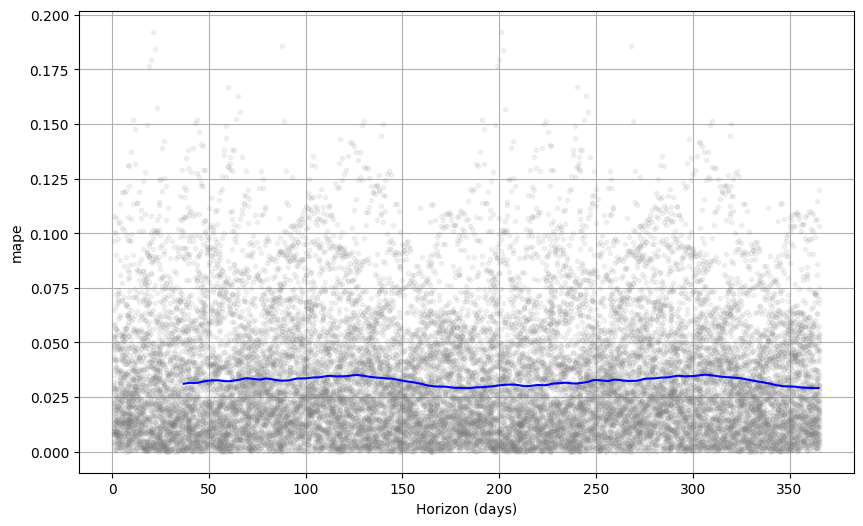

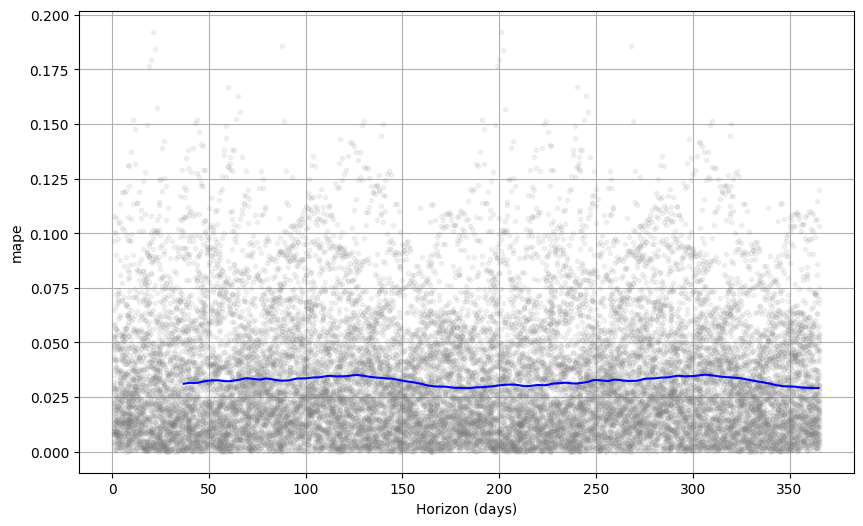

In [18]:
plot_cross_validation_metric(df_cv, metric='mape')

/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/finnvaughankraska/dev/gallaflow/explore/.venv/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


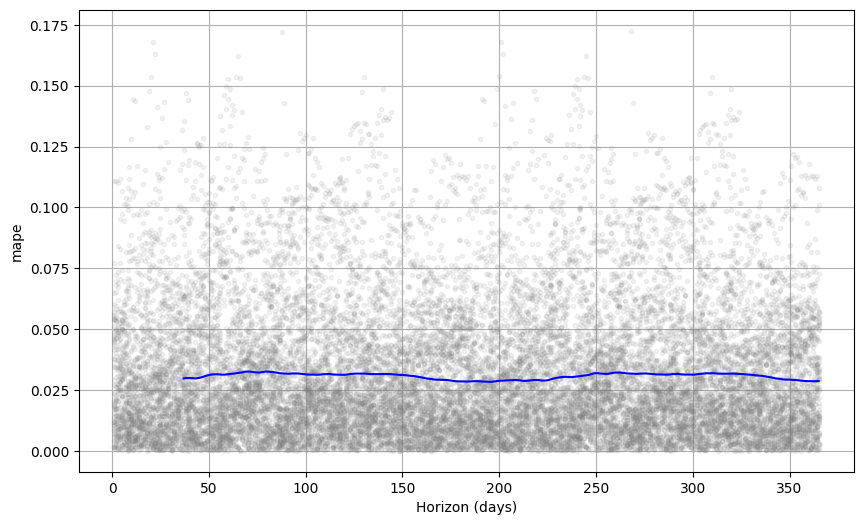

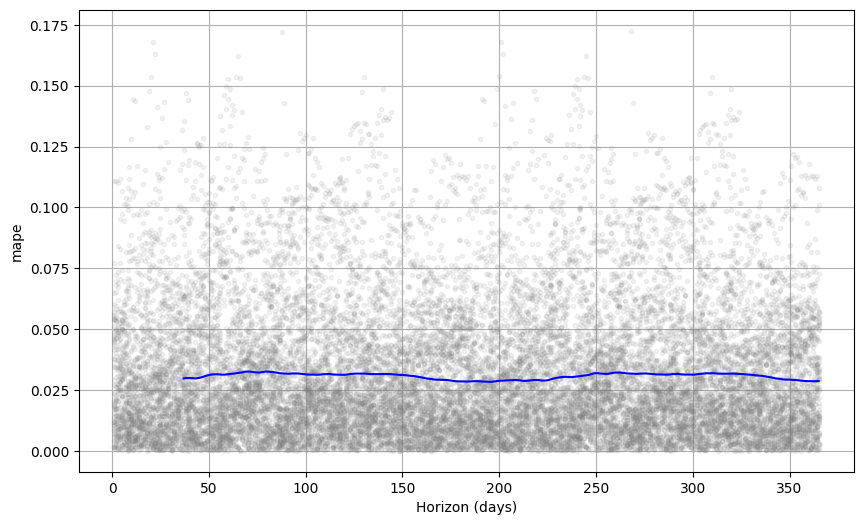

In [19]:
plot_cross_validation_metric(dfc_cv, metric='mape')

In [24]:
df_merged["y_true"] = np.exp(df_merged["y"])
df_merged["yhat_true"] = np.exp(df_merged["yhat"])
df_merged["residuals_true"] = df_merged["y_true"] - df_merged["yhat_true"]
df_merged

,TAVG_origValue,WTEQ_average,WTEQ_origValue,y,TAVG_lag_1,TAVG_lag_2,TAVG_lag_3,trend,yhat_lower,yhat_upper,...,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,residuals,y_true,yhat_true,residuals_true
ds,,,,,,,,,,,,,,,,,,,,,
1990-01-04,11.5,10.2,12.0,5.517453,3.9,10.9,19.2,6.311501,5.324619,6.031289,...,-0.100291,-0.100291,0.0,0.0,0.0,5.677110,-0.159657,249.0,292.104085,-43.104085
1990-01-05,14.5,10.3,12.0,5.594711,11.5,3.9,10.9,6.311501,5.334161,6.020275,...,-0.100231,-0.100231,0.0,0.0,0.0,5.678465,-0.083754,269.0,292.500065,-23.500065
1990-01-06,22.5,10.4,12.1,5.641907,14.5,11.5,3.9,6.311501,5.349498,6.034006,...,-0.100187,-0.100187,0.0,0.0,0.0,5.679613,-0.037706,282.0,292.836099,-10.836099
1990-01-07,25.0,10.6,12.3,5.631212,22.5,14.5,11.5,6.311501,5.322314,6.062716,...,-0.100158,-0.100158,0.0,0.0,0.0,5.678805,-0.047593,279.0,292.599530,-13.599530
1990-01-08,22.6,10.7,12.6,5.683580,25.0,22.5,14.5,6.311501,5.342573,6.039184,...,-0.100146,-0.100146,0.0,0.0,0.0,5.680178,0.003401,294.0,293.001681,0.998319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10,43.7,12.3,9.8,8.586719,45.9,47.3,46.8,6.311501,7.683856,8.388103,...,0.273800,0.273800,0.0,0.0,0.0,8.040339,0.546381,5360.0,3103.664154,2256.335846
2024-06-11,47.3,11.9,8.3,8.420682,43.7,45.9,47.3,6.311501,7.682654,8.367090,...,0.272158,0.272158,0.0,0.0,0.0,8.030651,0.390032,4540.0,3073.740777,1466.259223
2024-06-12,48.4,11.3,7.0,8.328451,47.3,43.7,45.9,6.311501,7.648915,8.346136,...,0.270206,0.270206,0.0,0.0,0.0,8.016676,0.311775,4140.0,3031.084290,1108.915710


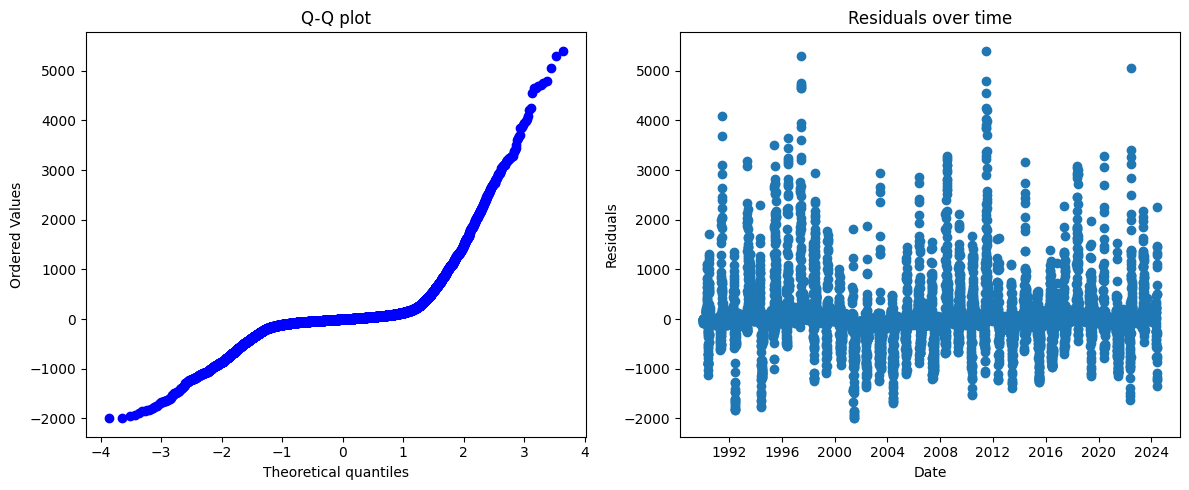

In [26]:
import scipy.stats as stats

residuals = df_merged["residuals_true"].values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q plot")

ax2.scatter(df_merged.index, residuals)
ax2.set_title("Residuals over time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()